In [1]:
# the aim of this notebook is to compute pixels lifetimes and distances between transient pixels and stable ones
# The script results in array "final_results" of shape (n,6), where n is number of trans pixels and 6 is features: 
# (t,z,y,x,neighbour_idx, distance, life)
# for this script to run you need to provide input image and the limit for splitting pixels into transient and stable
#  the script also import the analysis.py module from utils folder

In [2]:
img_path = '/home/tli_project/Desktop/test_lifetime/seg_1_211104_P36_N1_GFP.tif'
stab_path = '/home/tli_project/Desktop/test_lifetime/output/stable_211104_new.tif'
stab_limit = 10

save_path = '/home/tli_project/Desktop/test_lifetime/output/'
save_name = 'XX'

In [3]:
import matplotlib.pyplot as plt
import tifffile as tif
import numpy as np
from tqdm import tqdm
import utils.analysis as analysis
# from pykdtree.kdtree import KDTree
from scipy import spatial

In [4]:
neuron = tif.imread(img_path)
# make sure images are binary
neuron[neuron!=0] = 1

In [5]:
# either read the stable image or calculate it using the stable_px fuction 
# stable_n = tif.imread(stab_path)
stable_n = analysis.stable_px(neuron, 
                            st_limit = stab_limit, 
                            save=False, 
                            save_path=save_path, 
                            save_file=save_name, 
                            xy_pixel=0.076, 
                            z_pixel=0.4)
# make sure images are binary
stable_n[stable_n!=0] = 1 

calculating stable: 100%|██████████| 410459/410459 [00:09<00:00, 42474.00it/s]


In [6]:
# get the 4D_img of transient pixels
transient = neuron[9:] - stable_n[9:]

In [46]:
len(transient), len(np.argwhere(transient))

(80, 7948157)

In [47]:
# computing distances
scope = np.arange(stab_limit-1, len(neuron),1)
stable_PC = np.argwhere(stable_n==1)
trans_PC = np.argwhere(transient==1)
### the result will be saved as pointcloud: t,z,y,x,neigbour,distance
distances = []
for t in tqdm(scope):
    stable = stable_PC[stable_PC[:,0]==t]
    trans = trans_PC[trans_PC[:,0]==t]
    kd_tree = spatial.KDTree(stable)
    dist, idx = kd_tree.query(trans, k=1, workers=-1)
    closest = [stable[ind] for ind in idx]
    for i, px in enumerate(trans):
        new_px = np.array([px[0], px[1], px[2], px[3], closest[i], dist[i]], dtype=object)
        distances.append(new_px)
        # new_px = np.expand_dims(new_px, axis = 0)
        # np.concatenate((distances,new_px))

distances = np.array(distances)
print(distances.shape)

100%|██████████| 80/80 [00:17<00:00,  4.47it/s]

(7240578, 6)


In [7]:
# computing distances
scope = np.arange(stab_limit-1, len(neuron),1)
stable_PC1 = np.argwhere(stable_n==1)
trans_PC1 = np.argwhere(transient==1)
stable_PC1[:,1] = stable_PC1[:,1]*(400/76)
trans_PC1[:,1] = trans_PC1[:,1]*(400/76)
print(trans_PC1[:5], stable_PC1[:5])
### the result will be saved as pointcloud: t,z,y,x,neigbour,distance
distances = []
for t in tqdm(scope):
    stable = stable_PC1[stable_PC1[:,0]==t]
    # stable[:,1] = stable[:,1]*(400/76)
    trans = trans_PC1[trans_PC1[:,0]==t]
    # trans[:,1] = trans[:,1]*(400/76)
    kd_tree = spatial.KDTree(stable)
    dist, idx = kd_tree.query(trans, k=1, workers=-1)
    closest = [stable[ind] for ind in idx]
    for i, px in enumerate(trans):
        new_px = np.array([px[0], px[1], px[2], px[3], closest[i], dist[i]], dtype=object)
        distances.append(new_px)
        # new_px = np.expand_dims(new_px, axis = 0)
        # np.concatenate((distances,new_px))

distances = np.array(distances)
print(distances.shape)

[[  0  10 191 125]
 [  0  10 192 124]
 [  0  10 192 125]
 [  0  10 192 126]
 [  0  10 193 124]] [[  9  42 208 184]
 [  9  42 209 184]
 [  9  42 209 185]
 [  9  42 210 185]
 [  9  42 210 186]]


100%|██████████| 80/80 [00:35<00:00,  2.23it/s]


(7240578, 6)


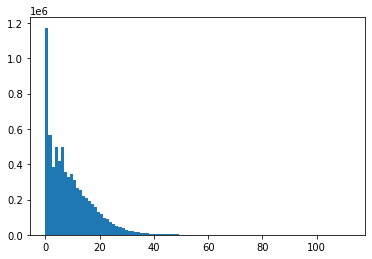

In [18]:
plot1 = plt.hist(distances[:,-1], bins=100)

In [9]:
# calculate lifetimes of neuron (not important for computing distances)
lifetimes = analysis.px_lifetimes(neuron)

calculating stable: 100%|██████████| 8640000/8640000 [01:16<00:00, 112908.55it/s]


In [10]:
# extending lifetimes to include all timepoints of each pixel with increasing lifetime
extended_lifes = []
for px in tqdm(lifetimes):
    t, z, y, x, l = px[0], px[1], px[2], px[3], px[4]
    for i in np.arange(px[-1]-1,-1,-1):
        t = px[0] - i
        l = px[-1] - i
        new_px = np.array([t, px[1], px[2], px[3], l])
        extended_lifes.append(new_px)
        # new_px = np.expand_dims(new_px, axis = 0)
        # np.concatenate((extended_lifes,new_px))

extended_lifes = np.array(extended_lifes)

100%|██████████| 3102012/3102012 [00:57<00:00, 54310.30it/s] 


In [11]:
# checking # of pixels in extended_lifes equals pixels in neuron 
len(lifetimes), len(extended_lifes), len(np.argwhere(neuron))

(3102012, 20261361, 20261361)

In [12]:
len(np.argwhere(transient))+len(np.argwhere(stable_n[9:])), len(np.argwhere(transient)), len(np.argwhere(neuron[9:]))

(18790593, 7948157, 18790593)

In [56]:
# filter the lifetimes for the transient pixels only (life smaller than limit)
trans_lifes1 = lifetimes[lifetimes[:,-1] < 9] 

trans_lifes = analysis.px_lifetimes(transient)

len(trans_lifes), len(trans_lifes1)

calculating stable: 100%|██████████| 8640000/8640000 [00:28<00:00, 298542.06it/s]


(2754248, 2659037)

In [13]:
# filter the lifetimes for the transient pixels only (life smaller than limit)
trans_lifes = analysis.px_lifetimes(transient)

# extend lifes to include pixels' previous time-points
# extending lifetimes to include all timepoints of each pixel with increasing lifetime
trans_lifes_extend = []
for px in tqdm(trans_lifes):
    t, z, y, x, l = px[0], px[1], px[2], px[3], px[4]
    for i in np.arange(px[-1]-1,-1,-1):
        t = px[0] - i
        l = px[-1] - i
        new_px = np.array([t, px[1], px[2], px[3], l])
        trans_lifes_extend.append(new_px)
        # new_px = np.expand_dims(new_px, axis = 0)
        # np.concatenate((extended_lifes,new_px))

trans_lifes_extend = np.array(trans_lifes_extend)

# checking # of pixels in extended_lifes equals pixels in neuron 
len(trans_lifes), len(trans_lifes_extend), len(np.argwhere(transient))

100%|██████████| 2754248/2754248 [00:40<00:00, 68044.97it/s] 


(2754248, 7948157, 7948157)

In [14]:
# combining lifetimes info with distances using KDtree
# you can either work with extendedlifes with lifetimes
scope = np.arange(stab_limit-1, len(neuron),1)
### the result will be saved as pointcloud: t,z,y,x,neigbour,distance,life
final_results = []
for t in tqdm(scope):
    t_dist = distances[distances[:,0]==t]
    t_lifes = trans_lifes_extend[trans_lifes_extend[:,0]==t]
    kd_tree = spatial.KDTree(t_dist[:,1:4])
    dist, idx = kd_tree.query(t_lifes[:,1:4], k=1, workers=-1)
    closest = [t_dist[ind] for ind in idx]
    for i, px in enumerate(t_lifes):
        new_px = np.array([px[0], px[1], px[2], px[3], closest[i][4], closest[i][5], px[4]], dtype=object)
        final_results.append(new_px)

final_results = np.array(final_results)
print(final_results.shape)

100%|██████████| 80/80 [01:57<00:00,  1.47s/it]


(7240578, 7)


In [61]:
trans_lifes_extend[(trans_lifes_extend[:,0]==11) & (trans_lifes_extend[:,1]==0) & (trans_lifes_extend[:,2]==186) & (trans_lifes_extend[:,3]>123)]

array([], shape=(0, 5), dtype=int64)

In [15]:
dist.sum()

0.0

Text(0.5, 0, 'distance of transient pixel to nearest stable')

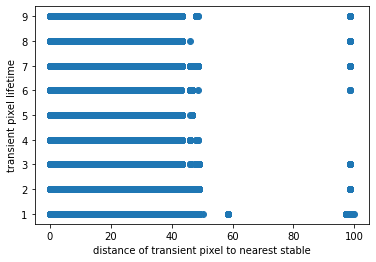

In [16]:
plot = plt.scatter(final_results[:,5], final_results[:,6])
plt.ylabel('transient pixel lifetime')
plt.xlabel('distance of transient pixel to nearest stable')

Text(0, 0.5, 'distance of transient px to nearest stable')

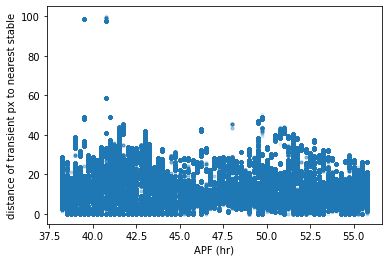

In [17]:
plot = plt.scatter(final_results[:,0]*0.25+36, final_results[:,5], marker='.', alpha=0.1)
plt.xlabel('APF (hr)')
plt.ylabel('distance of transient px to nearest stable')